In [2]:
"""This notebook finetunes the pretrained Transformer using personalized exoskeleton data
The exoskeleton data contains labeled pairs of kinematics and gait state
"""
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.test.is_built_with_cuda()
import os, sys
sys.path.append('../')
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import pyarrow.parquet as pq
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from datasets import WindowedGaitDataset, ToTensor, ExobootDataset
from gait_transformer import GaitTransformer
from save_best_model import SaveBestModel
from training_utils import phase_dist, unscale_kinematics, unscale_gait_state, calculate_gait_state_errors
from torch_training_utils import GaitLoss, EWC, enum_parameters
from torch.autograd import Variable
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42
import time
import datetime

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#RUN THIS TO SET UP COLAB
ON_COLAB = not True
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/Phase ML Data/'

2023-03-06 15:13:19.410697: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 15:13:20.306023: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-06 15:13:20.306165: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

Load up the vicon data

In [ ]:
!gsutil cp -r gs://ml_gait_estimation/r01_ordered_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/r01_randomized_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/dataport_ordered_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/dataport_randomized_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/gt_ordered_corrupt_time.csv .
!gsutil cp -r gs://ml_gait_estimation/gt_randomized_corrupt_time.csv .

In [ ]:
!gsutil cp -r gs://ml_gait_estimation/exoboot_AB01_data.csv .
!gsutil cp -r gs://ml_gait_estimation/exoboot_AB02_data.csv .
!gsutil cp -r gs://ml_gait_estimation/exoboot_AB03_data.csv .
!gsutil cp -r gs://ml_gait_estimation/exoboot_AB04_data.csv .
!gsutil cp -r gs://ml_gait_estimation/exoboot_AB05_data.csv .
!gsutil cp -r gs://ml_gait_estimation/exoboot_AB06_data.csv .
!gsutil cp -r gs://ml_gait_estimation/exoboot_AB07_data.csv .
!gsutil cp -r gs://ml_gait_estimation/exoboot_AB08_data.csv .
!gsutil cp -r gs://ml_gait_estimation/exoboot_AB09_data.csv .
!gsutil cp -r gs://ml_gait_estimation/exoboot_AB10_data.csv .


In [5]:
window_size = 150 #set the kinematics window size, how many iterations into the past we process

meas_scale = np.array([[-69.35951035,  27.62815047],\
                            [-456.18013759,  401.13782617],\
                            [-63.71649984,  22.06632622],\
                            [-213.4786175,   396.93801619],\
                            [-35.26603985,  20.78473636],\
                            [-20.95456523,  14.63961137],\
                              [0,1]]) #set up the scaling factors to scale the kinematics between 0 and 1

#set up scaling factors to scale the gait state
speed_scale = (0,2)
incline_scale = (-10,10)
stair_height_scale = (-1,1)

#aggregate all the exoboot data
all_filenames = ['exoboot_AB01_data.csv',
                 'exoboot_AB02_data.csv',
                 'exoboot_AB03_data.csv',
                 'exoboot_AB04_data.csv',
                 'exoboot_AB05_data.csv',
                 'exoboot_AB06_data.csv',
                 'exoboot_AB07_data.csv',
                 'exoboot_AB08_data.csv',
                 'exoboot_AB09_data.csv',
                 'exoboot_AB10_data.csv']

if ON_COLAB:
    all_filenames[:] = [drive_path + i for i in all_filenames]

#SELECT WHICH SUBJECT TO FINETUNE
# SUBJ_ID = 'AB03'
SUBJ_ID = 'XSUB'

#set to True if we want to personalize on an individual using the other subjects' data
DO_XVAL = not True and SUBJ_ID != 'XSUB' 

#set to True if we want to add other subjects' data into the finetuned subject's data pool
AUGMENT_REGULAR_WITH_OTHER_EXOBOOT = not True and SUBJ_ID != 'XSUB'

# aggregate files
if SUBJ_ID == 'XSUB': #if we finetune the x-subject model, use all the data
    exo_filenames_subj = [i for i in all_filenames]
    
else: #select only the data for the individual subject
    exo_filenames_not_in_subj = [i for i in all_filenames if SUBJ_ID not in i]
    exo_filenames_subj = [i for i in all_filenames if SUBJ_ID in i]

    print(exo_filenames_not_in_subj)
    #extract data for files outside the subject
    exo_dfs_not_in_subj = [pd.read_csv(filename) for filename in exo_filenames_not_in_subj]
    exoboot_data_not_in_subj = pd.concat(exo_dfs_not_in_subj)

print(exo_filenames_subj)


#extract data for the subject
exo_dfs_in_subj = [pd.read_csv(filename) for filename in exo_filenames_subj]
exoboot_data_in_subj = pd.concat(exo_dfs_in_subj)



if DO_XVAL:
    exoboot_train_dataset = ExobootDataset(gait_data=exoboot_data_not_in_subj,
                                  meas_scale=meas_scale,
                                  window_size = window_size,
                                  speed_scale = speed_scale,
                                  incline_scale = incline_scale,
                                  stair_height_scale = stair_height_scale,
                                  transform=ToTensor())


    exoboot_val_dataset = ExobootDataset(gait_data=exoboot_data_in_subj,
                                  meas_scale=meas_scale,
                                  window_size = window_size,
                                  speed_scale = speed_scale,
                                  incline_scale = incline_scale,
                                  stair_height_scale = stair_height_scale,
                                  transform=ToTensor())

    print('{:>5,} training samples'.format(len(exoboot_train_dataset)))
    print('{:>5,} validation samples'.format(len(exoboot_val_dataset)))
    
else:
    exoboot_data = exoboot_data_in_subj
    dataset = ExobootDataset(gait_data=exoboot_data,
                                  meas_scale=meas_scale,
                                  window_size = window_size,
                                  speed_scale = speed_scale,
                                  incline_scale = incline_scale,
                                  stair_height_scale = stair_height_scale,
                                  transform=ToTensor())

    # Calculate the number of samples to include in each set.
    # Do a 75-25 train-test split
    train_size = int(0.75 * len(dataset))
    val_size = len(dataset) - train_size


    # Divide the dataset by randomly selecting samples.
    exoboot_train_dataset, exoboot_val_dataset = random_split(dataset, [train_size, val_size])
    
    #append the other exoboot data into the training set
    if AUGMENT_REGULAR_WITH_OTHER_EXOBOOT:
        print('AUGMENT_REGULAR_WITH_OTHER_EXOBOOT')
        non_subject_exoboot_dataset = ExobootDataset(gait_data=exoboot_data_not_in_subj,
                                  meas_scale=meas_scale,
                                  window_size = window_size,
                                  speed_scale = speed_scale,
                                  incline_scale = incline_scale,
                                  stair_height_scale = stair_height_scale,
                                  transform=ToTensor())
        
        # Calculate the number of samples to include in each set.
        ratio_rehearse_other_exoboot = 1
        train_size = int(ratio_rehearse_other_exoboot * len(exoboot_train_dataset))
        non_subject_exoboot_train_dataset, _ = random_split(non_subject_exoboot_dataset, [train_size, len(non_subject_exoboot_dataset) - train_size])
    
        val_size = int(ratio_rehearse_other_exoboot * len(exoboot_val_dataset))
        non_subject_exoboot_val_dataset, _ = random_split(non_subject_exoboot_dataset, [val_size, len(non_subject_exoboot_dataset) - val_size])

    
        # exoboot_train_dataset = torch.utils.data.ConcatDataset([exoboot_train_dataset, non_subject_dataset])
            
    print(f'{SUBJ_ID} Samples: ')
    print('{:>5,} training samples'.format(len(exoboot_train_dataset)))
    print('{:>5,} validation samples'.format(len(exoboot_val_dataset)))
    
    if AUGMENT_REGULAR_WITH_OTHER_EXOBOOT:
        print(f'Non {SUBJ_ID} Samples: ')
        print('{:>5,} training samples'.format(len(non_subject_exoboot_train_dataset)))
        print('{:>5,} training samples'.format(len(non_subject_exoboot_val_dataset)))

len_exoboot_train_dataset = len(exoboot_train_dataset)
len_exoboot_val_dataset = len(exoboot_val_dataset)




['exoboot_AB01_data.csv', 'exoboot_AB02_data.csv', 'exoboot_AB03_data.csv', 'exoboot_AB04_data.csv', 'exoboot_AB05_data.csv', 'exoboot_AB06_data.csv', 'exoboot_AB07_data.csv', 'exoboot_AB08_data.csv', 'exoboot_AB09_data.csv', 'exoboot_AB10_data.csv']
XSUB Samples: 
176,484 training samples
58,829 validation samples


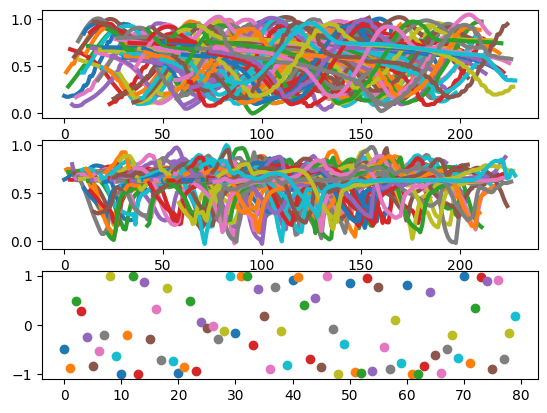

In [7]:
fig, axs = plt.subplots(3,1)

for i in range(0,80):
  y = exoboot_train_dataset[i+window_size]['meas'][:,0]
  y1 = exoboot_train_dataset[i+window_size]['meas'][:,4]
  x = np.array([j for j in range(len(y))])
  x = x + i

  yy = exoboot_train_dataset[i+window_size]['state'][:,0]
  axs[0].plot(x,y,linewidth=3)
  axs[1].plot(x,y1,linewidth=3)
  axs[2].plot(i,yy,'o',linewidth=3)



In [8]:
#LOAD IN STAIRS FINETUNING

all_filenames = ['finetune_exoboot_Vicon_AB01-Scarlet_stairs1_processed.csv',
                'finetune_exoboot_Vicon_AB02-Parallel_stairs1_processed.csv',
                'finetune_exoboot_Vicon_AB03-Hammer_stairs1_processed.csv',
                'finetune_exoboot_Vicon_AB04-Kronecker_stairs1.csv',
                'finetune_exoboot_Vicon_AB05-Eagle_stairs1.csv',
                'finetune_exoboot_Vicon_AB06-West_stairs1_processed.csv',
                'finetune_exoboot_Vicon_AB07-Futon_stairs2_processed.csv',
                'finetune_exoboot_Vicon_AB08-CHaos_stairs1_processed.csv',
                'finetune_exoboot_Vicon_AB09-Brand_stairs1.csv',
                'finetune_exoboot_Vicon_AB10-DaVinci_stairs1_processed.csv']

if ON_COLAB:
    all_filenames[:] = [drive_path + i for i in all_filenames]

#extract data for the subject
if SUBJ_ID == 'XSUB':
    stairs_dfs_list = [pd.read_csv(filename) for filename in all_filenames]
else:
    stairs_dfs_list = [pd.read_csv(filename) for filename in all_filenames if SUBJ_ID in filename]
    
exo_stairs_dfs = pd.concat(stairs_dfs_list)


dataset = ExobootDataset(gait_data=exo_stairs_dfs,
                              meas_scale=meas_scale,
                              window_size = window_size,
                              speed_scale = speed_scale,
                              incline_scale = incline_scale,
                              stair_height_scale = stair_height_scale,
                              transform=ToTensor())
# Calculate the number of samples to include in each set.
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size


# Divide the dataset by randomly selecting samples.
exo_stairs_train_dataset, exo_stairs_val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(len(exo_stairs_train_dataset)))
print('{:>5,} validation samples'.format(len(exo_stairs_val_dataset)))
    
len_exoboot_train_dataset = len(exoboot_train_dataset)
len_exoboot_val_dataset = len(exoboot_val_dataset)

# print(exo_stairs_dfs.head(10))
# print(exo_stairs_dfs.iloc[420:470])
print(exo_stairs_dfs.iloc[160:250])


151,119 training samples
50,373 validation samples
     foot_angles  foot_vel_angles  shank_angles  shank_vel_angles  \
160   -55.637490      -105.477882    -51.405726       -109.050987   
161   -56.025576       -46.250850    -52.309941       -144.172938   
162   -55.969496        35.567215    -53.294227       -144.294890   
163   -54.182857       145.110363    -54.097652       -128.776597   
164   -53.225359       161.027877    -54.668840       -120.392451   
..           ...              ...           ...               ...   
245    -0.088621         8.617797    -23.406123         44.881940   
246     0.041603        12.462505    -23.646428         47.778281   
247     0.041603        12.462505    -23.646428         47.778281   
248     0.095512        13.624445    -23.276799         48.296574   
249     0.095512        13.624445    -23.276799         48.296574   

     heel_acc_forward  heel_acc_up        dt  phase_ground_truth  \
160          3.190119     2.100143  0.010013        

In [9]:
window_size = 150
meas_scale = np.array([[-69.35951035,  27.62815047],\
                        [-456.18013759,  401.13782617],\
                        [-63.71649984,  22.06632622],\
                        [-213.4786175,   396.93801619],\
                        [-35.26603985,  20.78473636],\
                        [-20.95456523,  14.63961137],\
                          [0,1]])

speed_scale = (0,2)
incline_scale = (-10,10)
stair_height_scale = (-1,1)

filename_dataport_ordered = 'dataport_ordered_stairs_label_corrupt_time.csv'
filename_dataport_randomized = 'dataport_randomized_stairs_label_corrupt_time.csv'

filename_r01_ordered = 'r01_ordered_stairs_label_corrupt_time.csv'
filename_r01_randomized = 'r01_randomized_stairs_label_corrupt_time.csv'

filename_gt_ordered = 'gt_ordered_stairs_label_corrupt_time.csv'
filename_gt_randomized = 'gt_randomized_stairs_label_corrupt_time.csv'

if ON_COLAB:
    filename_r01_ordered = drive_path+filename_r01_ordered
    filename_r01_randomized = drive_path+filename_r01_randomized
    filename_dataport_ordered = drive_path+filename_dataport_ordered
    filename_dataport_randomized = drive_path+filename_dataport_randomized
    filename_gt_ordered = drive_path+filename_gt_ordered
    filename_gt_randomized = drive_path+filename_gt_randomized
    

DO_DECIMATION = not True
if DO_DECIMATION:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized, nrows=1000)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered, nrows=1000)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered, nrows=1000)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized, nrows=1000)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered, nrows=1000)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized, nrows=1000)

    
else:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized)


# REMOVE RANDOM SUBJECTS FOR X-VALIDATION
#FROM R01, remove two: AB02 and AB06
#FROM DATAPORT, remove three: AB09, AB05, and AB10
#FROM GT, remove six, AB25, AB28, AB30, AB20, AB12, AB09
REMOVE_SUBS_XVAL = True

if REMOVE_SUBS_XVAL:
    #r01 ordered
    index_sub_remove_r01 = gait_data_r01_ordered[ (gait_data_r01_ordered['subj_id'] == 2) | (gait_data_r01_ordered['subj_id'] == 6) ].index
    gait_data_r01_ordered_val = gait_data_r01_ordered.iloc[index_sub_remove_r01]
    gait_data_r01_ordered.drop(index_sub_remove_r01 , inplace=True)
    
    #r01 randomized
    index_sub_remove_r01 = gait_data_r01_randomized[ (gait_data_r01_randomized['subj_id'] == 2) | (gait_data_r01_randomized['subj_id'] == 6) ].index
    gait_data_r01_randomized_val = gait_data_r01_randomized.iloc[index_sub_remove_r01]
    gait_data_r01_randomized.drop(index_sub_remove_r01 , inplace=True)
    
    # print(gait_data_r01_ordered.head())
    # print(gait_data_r01_ordered_val.head())
    
    #dataport ordered
    index_sub_remove_dataport = gait_data_dataport_ordered[ (gait_data_dataport_ordered['subj_id'] == 9) | 
                                                           (gait_data_dataport_ordered['subj_id'] == 5) |
                                                          (gait_data_dataport_ordered['subj_id'] == 10)].index

    gait_data_dataport_ordered_val = gait_data_dataport_ordered.iloc[index_sub_remove_dataport]
    gait_data_dataport_ordered.drop(index_sub_remove_dataport , inplace=True)
    
    #dataport randomized
    index_sub_remove_dataport = gait_data_dataport_randomized[ (gait_data_dataport_randomized['subj_id'] == 9) | 
                                                           (gait_data_dataport_randomized['subj_id'] == 5) |
                                                          (gait_data_dataport_randomized['subj_id'] == 10)].index

    gait_data_dataport_randomized_val = gait_data_dataport_randomized.iloc[index_sub_remove_dataport]
    gait_data_dataport_randomized.drop(index_sub_remove_dataport , inplace=True)
    
    #gt ordered
    index_sub_remove_gt = gait_data_gt_ordered[ (gait_data_gt_ordered['subj_id'] == 25) | 
                                               (gait_data_gt_ordered['subj_id'] == 28) |
                                              (gait_data_gt_ordered['subj_id'] == 30) |
                                              (gait_data_gt_ordered['subj_id'] == 20) |
                                              (gait_data_gt_ordered['subj_id'] == 12) |
                                              (gait_data_gt_ordered['subj_id'] == 9)].index
    
    gait_data_gt_ordered_val = gait_data_gt_ordered.iloc[index_sub_remove_gt]
    gait_data_gt_ordered.drop(index_sub_remove_gt , inplace=True)
    
    #gt randomized
    index_sub_remove_gt = gait_data_gt_randomized[ (gait_data_gt_randomized['subj_id'] == 25) | 
                                               (gait_data_gt_randomized['subj_id'] == 28) |
                                              (gait_data_gt_randomized['subj_id'] == 30) |
                                              (gait_data_gt_randomized['subj_id'] == 20) |
                                              (gait_data_gt_randomized['subj_id'] == 12) |
                                              (gait_data_gt_randomized['subj_id'] == 9)].index
    
    gait_data_gt_randomized_val = gait_data_gt_randomized.iloc[index_sub_remove_gt]
    gait_data_gt_randomized.drop(index_sub_remove_gt , inplace=True)
    
    #concatenate
    gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                          gait_data_dataport_ordered, gait_data_dataport_randomized,\
                          gait_data_gt_ordered, gait_data_gt_randomized])
    
    gait_data_val = pd.concat([gait_data_r01_ordered_val, gait_data_r01_randomized_val,\
                              gait_data_dataport_ordered_val, gait_data_dataport_randomized_val,\
                              gait_data_gt_ordered_val, gait_data_gt_randomized_val])

    # gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized])
    # gait_data_val = pd.concat([gait_data_r01_ordered_val, gait_data_r01_randomized_val])

    

    vicon_train_dataset = WindowedGaitDataset(gait_data=gait_data,
                                                meas_scale=meas_scale,
                                                window_size = window_size,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                stair_height_scale = stair_height_scale,
                                                transform=ToTensor())
    
    vicon_val_dataset = WindowedGaitDataset(gait_data=gait_data_val,
                                                meas_scale=meas_scale,
                                                window_size = window_size,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                stair_height_scale = stair_height_scale,
                                                transform=ToTensor())
    
    print('{:>5,} training samples'.format(len(vicon_train_dataset)))
    print('{:>5,} validation samples'.format(len(vicon_val_dataset)))

    #for computing EWC, extract only the rows where stairs is true, or where is moving is false
    gait_data_stairs_true = gait_data.loc[ (np.abs(gait_data['stair_height']) > 0.05)]
    # gait_data_stairs_true = gait_data.iloc[index_stairs_true]
    
    gait_data_val_stairs_true = gait_data_val.loc[(np.abs(gait_data_val['stair_height']) > 0.05) ]
    # gait_data_val_stairs_true = gait_data_val.iloc[index_val_stairs_true]
    
    
    # gait_data_stairs_true = gait_data[(gait_data['stair_height'] > 0) | (gait_data['stair_height'] < 0)]
    # gait_data_val_stairs_true = gait_data_val[(gait_data_val['stair_height'] > 0) | (gait_data['stair_height'] < 0)]

    print(gait_data_stairs_true.head(10))

    vicon_train_dataset_stairs = WindowedGaitDataset(gait_data=gait_data_stairs_true,
                                                meas_scale=meas_scale,
                                                window_size = window_size,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                stair_height_scale = stair_height_scale,
                                                transform=ToTensor())
    
    vicon_val_dataset_stairs = WindowedGaitDataset(gait_data=gait_data_val_stairs_true,
                                                meas_scale=meas_scale,
                                                window_size = window_size,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                stair_height_scale = stair_height_scale,
                                                transform=ToTensor())
    
    # Calculate the number of stairs/moving samples to include in finetuning
    ratio_rehearse_train_stairs = 0.01
    ratio_rehearse_val_stairs = 0.01
    
    len_vicon_train_dataset_stairs_finetune = int(ratio_rehearse_train_stairs*len_exoboot_train_dataset)
    len_vicon_val_dataset_stairs_finetune = int(ratio_rehearse_val_stairs*len_exoboot_val_dataset)
 
    vicon_train_dataset_stairs_finetune, _ = random_split(vicon_train_dataset_stairs, 
                                                                 [len_vicon_train_dataset_stairs_finetune, 
                                                                  len(vicon_train_dataset_stairs) - len_vicon_train_dataset_stairs_finetune])
    
    vicon_val_dataset_stairs_finetune, _ = random_split(vicon_val_dataset_stairs, 
                                                            [len_vicon_val_dataset_stairs_finetune, 
                                                             len(vicon_val_dataset_stairs) - len_vicon_val_dataset_stairs_finetune])

    print('{:>5,} training samples'.format(len(vicon_train_dataset_stairs_finetune)))
    print('{:>5,} validation samples'.format(len(vicon_val_dataset_stairs_finetune)))
    
    #Calculate the number of general vicon distribution samples to include in finetuning
    # Calculate the number of stairs/moving samples to include in finetuning
    ratio_rehearse_train = 10
    ratio_rehearse_val = 10
    len_vicon_train_dataset_finetune = int(ratio_rehearse_train*len_exoboot_train_dataset)
    len_vicon_val_dataset_finetune = int(ratio_rehearse_val*len_exoboot_val_dataset)
 
    vicon_train_dataset_finetune, _ = random_split(vicon_train_dataset, 
                                                                 [len_vicon_train_dataset_finetune, 
                                                                  len(vicon_train_dataset) - len_vicon_train_dataset_finetune])
    
    vicon_val_dataset_finetune, _ = random_split(vicon_val_dataset, 
                                                            [len_vicon_val_dataset_finetune, 
                                                             len(vicon_val_dataset) - len_vicon_val_dataset_finetune])
    
    print('{:>5,} training samples'.format(len(vicon_train_dataset_finetune)))
    print('{:>5,} validation samples'.format(len(vicon_val_dataset_finetune)))
    
else:
    gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                          gait_data_dataport_ordered, gait_data_dataport_randomized,\
                          gait_data_gt_ordered, gait_data_gt_randomized])
    # gait_data = gait_data_r01_randomized
    # gait_data = pd.concat([gait_data_r01_randomized, gait_data_dataport_randomized])
    
    dataset = WindowedGaitDataset(gait_data=gait_data,
                                            meas_scale=meas_scale,
                                            window_size = window_size,
                                            speed_scale = speed_scale,
                                            incline_scale = incline_scale,
                                            stair_height_scale = stair_height_scale,
                                            transform=ToTensor())  
    # Create a 90-10 train-validation split.

    # Calculate the number of samples to include in each set.
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size


    # Divide the dataset by randomly selecting samples.
    vicon_train_dataset, vicon_val_dataset = random_split(dataset, [train_size, val_size])
    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))




11,959,407 training samples
4,477,713 validation samples
        foot_angle  foot_vel_angle  shank_angle  shank_vel_angle  \
141867   10.959341      -76.390927     6.757636       -92.770189   
141868    6.539610      -70.740000     7.739309       -71.674000   
141869    5.979485      -73.910461     7.168295       -75.235634   
141870    5.124616      -77.463232     6.267472       -81.880038   
141871    4.185067      -73.528571     5.170837       -87.612801   
141872    3.594854      -65.667533     4.339335       -91.190457   
141873    2.979457      -52.917202     3.264723       -94.978601   
141874    2.635565      -43.031653     2.458057       -96.532404   
141875    2.327461      -32.715548     1.537968       -96.626348   
141876    2.074022      -23.139683     0.524102       -94.192377   

        heel_acc_forward  heel_acc_upward     phase     speed   incline  \
141867         -5.859549        -0.580513  0.000000  0.314171  2.267627   
141868          0.000000         0.000000  0

In [10]:
#SET UP EXOBOOT DATALOADERS
#SET BATCH SIZE
BATCH_SIZE_TRAIN = 1024
BATCH_SIZE_VALIDATE = 256*8
NUM_WORKERS = 2

train_dataset = torch.utils.data.ConcatDataset([exoboot_train_dataset])
val_dataset = torch.utils.data.ConcatDataset([exoboot_val_dataset])
    
ADD_VICON_TO_FINETUNING = True

if ADD_VICON_TO_FINETUNING:
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, vicon_train_dataset_finetune, vicon_train_dataset_stairs_finetune])
    val_dataset = torch.utils.data.ConcatDataset([val_dataset, vicon_val_dataset_finetune, vicon_val_dataset_stairs_finetune])

ADD_EXOSTAIRS_TO_FINETUNING = True

if ADD_EXOSTAIRS_TO_FINETUNING:
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, exo_stairs_train_dataset])
    val_dataset = torch.utils.data.ConcatDataset([val_dataset, exo_stairs_val_dataset])

if AUGMENT_REGULAR_WITH_OTHER_EXOBOOT:
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, non_subject_exoboot_train_dataset])
    val_dataset = torch.utils.data.ConcatDataset([val_dataset, non_subject_exoboot_val_dataset])

    
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            shuffle=True,
            batch_size = BATCH_SIZE_TRAIN, # Trains with this batch size.
            pin_memory=True,
            num_workers=NUM_WORKERS
        )


# For validation the order doesn't matter, so we'll just read them sequentially.
#try shuffle off see if it fixes
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            shuffle=True,
            batch_size = BATCH_SIZE_VALIDATE, # Evaluate with this batch size.
            pin_memory=True,
            num_workers=NUM_WORKERS
        )

print(len(train_dataloader.dataset))
print(len(validation_dataloader.dataset))

# print(len(vicon_val_dataset))

    



2094207
698080


In [11]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
model_nickname = 'apollyon-three-stairs'

# data_filename = [i for i in all_filenames if SUBJ_ID in i][0]

subj_filename_id = SUBJ_ID
if DO_XVAL:
  subj_filename_id = subj_filename_id+'_xval'

# print(data_filename)
if ON_COLAB:
  output_dir = f'{drive_path}/full_models/{model_nickname}/finetune_{subj_filename_id}_exoboot/'
else:
  output_dir = f'../full_models/{model_nickname}/finetune_{subj_filename_id}_exoboot/'


# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

checkpoint_dir = 'checkpoints/'
if not os.path.exists(output_dir+checkpoint_dir):
    os.makedirs(output_dir+checkpoint_dir)



Saving model to ../full_models/apollyon-three-stairs/finetune_XSUB_exoboot/


Initialize Models

In [12]:
# Model parameters
dim_val = 32 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
n_decoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 7 # The number of input variables. 1 if univariate forecasting.
enc_seq_len = 150 # length of input given to encoder. Can have any integer value.
dec_seq_len = 1 # length of input given to decoder. Can have any integer value.

dropout_encoder = 0.1
dropout_decoder = 0.1
dropout_pos_enc = 0.0
dropout_regression = 0.1 
dim_feedforward_encoder = 512
dim_feedforward_decoder = 512

num_predicted_features = 5 # The number of output variables. 

model = GaitTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_decoder=dropout_decoder,
    dropout_pos_enc=dropout_pos_enc,
    dropout_regression=dropout_regression,
    num_predicted_features=num_predicted_features,
    dim_feedforward_encoder=dim_feedforward_encoder,
    dim_feedforward_decoder=dim_feedforward_decoder,
)

def enum_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        total_params+=params
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
enum_parameters(model)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

model.to(device)


#LOAD IN PRETRAINED MODEL
if ON_COLAB:
  model_dir = f'{drive_path}/full_models/{model_nickname}/model_save_xval/'
else:
  model_dir = f'../full_models/{model_nickname}/model_save_xval/'

checkpoint = torch.load(model_dir+'ml_gait_estimator_dec_best_model.tar',map_location=torch.device(device))
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss: {loss}')
epoch = checkpoint['epoch']

#Set up start of sequence token
SOS_token = 100 * torch.ones(1, 1, num_predicted_features).to(device).requires_grad_(False)

#load the model anew
model.load_state_dict(g)



Total Trainable Params: 319141
Using GPU.
Lowest Loss: 0.11826772387912407


<All keys matched successfully>

Load up EWC

In [13]:
#set up Fisher loss
#we'll need the old vicon data for this
#SET BATCH SIZE
BATCH_SIZE_VICON = 2048//2
NUM_WORKERS_VICON = 4

lossfcn_ewc = GaitLoss(w_phase=2, w_speed=4, w_incline=10, w_stairs=4)

# For validation the order doesn't matter, so we'll just read them sequentially.
vicon_prediction_dataloader = DataLoader(vicon_val_dataset, batch_size=BATCH_SIZE_VICON,shuffle=False,num_workers=NUM_WORKERS_VICON)
# fisher_mats_path = model_dir+f'ewc_fisher_matrices_oos_data_only_{model_nickname}.pt'
fisher_mats_path = model_dir+f'ewc_fisher_matrices_gait_loss_weights_{model_nickname}.pt'

COMPUTE_FISHER_MATS = not True
ewc = EWC(model=model, fisher_importance=1e0, fisher_mats_path=fisher_mats_path, 
          dataloader=vicon_prediction_dataloader, SOS_token=SOS_token, 
          device=device, COMPUTE_FISHER_MATS=COMPUTE_FISHER_MATS, lossfcn=lossfcn_ewc)
print('Initialized Models')


Loading precomp mats
Importance: 1.0
Initialized Models


In [ ]:
print(fisher_mats_path)
# torch.save(ewc._fisher_matrices, fisher_mats_path)
print(ewc._fisher_matrices)





In [14]:
best_model_name = 'ml_gait_estimator_dec_best_model.tar'
save_best_model = SaveBestModel(output_dir+best_model_name)

torch.autograd.set_detect_anomaly(True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.998), eps=1e-9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, threshold=0.01, verbose=True,min_lr=1e-8)


epochs = 4
SAVE_EVERY_EPOCH = 1
if not DO_XVAL:
    if not AUGMENT_REGULAR_WITH_OTHER_EXOBOOT:
        epochs = 10
        SAVE_EVERY_EPOCH = 5
    else:
        epochs = 10
        SAVE_EVERY_EPOCH = 5

lossfcn = GaitLoss(w_phase=2, w_speed=4, w_incline=10, w_stairs=2)


#Extract index for time steps
DT_IDX = 6



training_RMSEs = []
validation_RMSEs = []
ews_losses_training = []
ews_losses_val = []

# Measure the total training time for the whole run.
total_t0 = time.time()



for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i+1, epochs))
    print('Training...')

    lr = optimizer.param_groups[0]['lr']
    print(f'Learning Rate: {lr}')


    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()
    step_ct = 0
    for step, batch in enumerate(train_dataloader):
        step_ct += 1
        # for step, batch in enumerate([first_batch] * 200):

        
        optimizer.zero_grad()   
        
        b_input = batch['meas'].to(device)
        b_state = batch['state'].to(device)
        
        tgt = SOS_token.repeat(b_state.shape[0], 1, 1)

        dts = b_input[:,:,DT_IDX]
        dts = torch.unsqueeze(dts, dim=-1)

        prediction = model(b_input,tgt, dts)
        
        #compute regular loss
        loss = lossfcn(prediction, b_state)
        normal_loss_value = loss.item()
        # print('normal loss')
        # print(normal_loss_value)

        #update loss with Fisher loss
        ewc_loss = ewc.penalty(model)
        ews_losses_training.append(ewc_loss.item())

        loss += ewc_loss
        # print('ewc loss')
        # print(ewc_loss)

        #backprop
        loss.backward()
        #print(model.layer2.weight[0][0:10])
        #print(model.layer2.weight.grad[0][0:10])

        optimizer.step()
        #print(model.layer2.weight[0][0:10])
        #print(model.layer2.weight.grad[0][0:10])

        loss_value = normal_loss_value

        # Progress update every 40 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            print(loss_value)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss_value

    # Update the learning rate.
    # scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / step_ct           
    training_RMSEs.append(avg_train_loss)
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # Save to checkpoints
    #save every 1 epochs
    if (epoch_i + 1) % SAVE_EVERY_EPOCH == 0:
        print('Saving model checkpoint')
        model_name = f"ml_gait_estimator_dec_checkpoint_{epoch_i+1}.tar"
        path_name = output_dir+checkpoint_dir+model_name
        print(path_name)
        torch.save({
                    'epoch': epoch_i + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    }, path_name)
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    
    
    step_ct = 0
    for batch in validation_dataloader:
    #for batch in train_dataloader:
    # for step, batch in enumerate([first_batch] * 10):
        step_ct += 1

        b_input = batch['meas'].to(device)
        b_state = batch['state'].to(device)
        
        # b_state = b_state[:,:,:4]
        
        tgt = SOS_token.repeat(b_state.shape[0], 1, 1)
        dts = b_input[:,:,DT_IDX]
        dts = torch.unsqueeze(dts, dim=-1)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input, tgt, dts)

        loss = lossfcn(outputs, b_state)
        normal_loss_value = loss.item()
        
        #print(loss)
        loss_value = loss.item()
        #print(loss_rmse)
        
        #update loss with Fisher loss
        ewc_loss = ewc.penalty(model)
        ews_losses_val.append(ewc_loss.item())
        loss_value += ewc_loss.item()

        

        # Accumulate the validation loss.
        total_eval_loss += loss_value


    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / step_ct
    
    #schedule PlateauLoss
    scheduler.step(avg_val_loss)
    
    validation_RMSEs.append(avg_val_loss)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    #save best model
    save_best_model(
        avg_val_loss, epoch_i+1, model, optimizer, lossfcn
    )


print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

print("Saving model to %s" % output_dir)

#save model params
model_name = 'ml_gait_estimator_dec_params.pt'
torch.save(model.state_dict(), output_dir+model_name)

model_name = 'ml_gait_estimator_dec_full.pt'
torch.save(model, output_dir+model_name)

#save checkpoint
model_name = f"ml_gait_estimator_dec_checkpoint_{epoch_i}.tar"
torch.save({'epoch': epoch_i+1,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'loss': loss.item(),
                      }, output_dir+checkpoint_dir+model_name)


======== Epoch 1 / 10 ========
Training...
Learning Rate: 0.001
  Batch   100  of  2,046.    Elapsed: 0:01:08.
0.265787810087204
  Batch   200  of  2,046.    Elapsed: 0:02:15.
0.19814364612102509
  Batch   300  of  2,046.    Elapsed: 0:03:21.
0.20083491504192352
  Batch   400  of  2,046.    Elapsed: 0:04:28.
0.1854633092880249
  Batch   500  of  2,046.    Elapsed: 0:05:34.
0.18481796979904175
  Batch   600  of  2,046.    Elapsed: 0:06:42.
0.18802964687347412
  Batch   700  of  2,046.    Elapsed: 0:07:49.
0.18035297095775604
  Batch   800  of  2,046.    Elapsed: 0:08:56.
0.17783118784427643
  Batch   900  of  2,046.    Elapsed: 0:10:02.
0.20139670372009277
  Batch 1,000  of  2,046.    Elapsed: 0:11:09.
0.17423848807811737
  Batch 1,100  of  2,046.    Elapsed: 0:12:15.
0.19537092745304108
  Batch 1,200  of  2,046.    Elapsed: 0:13:22.
0.18525609374046326
  Batch 1,300  of  2,046.    Elapsed: 0:14:28.
0.19025632739067078
  Batch 1,400  of  2,046.    Elapsed: 0:15:35.
0.20600110292434692


0.13414524804221745


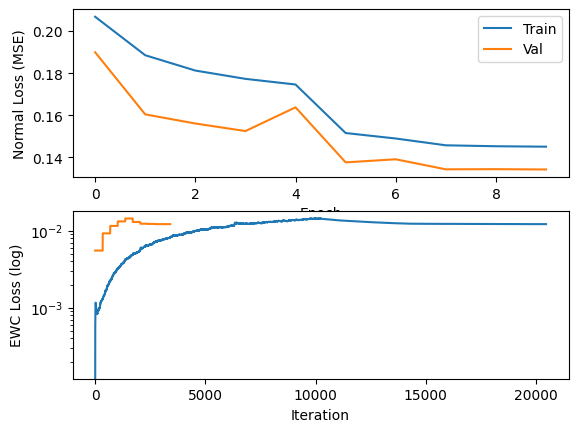

In [15]:
training_RMSEs = np.array(training_RMSEs)
validation_RMSEs = np.array(validation_RMSEs)
fig, axs = plt.subplots(2,1)
axs[0].plot(training_RMSEs,'-',label='Train')
axs[0].set_ylabel('Normal Loss (MSE)')
axs[0].plot(validation_RMSEs,'-',label='Val')
axs[0].set_xlabel('Epoch')
axs[0].legend()


axs[1].plot(ews_losses_training,'-',label='Train')
axs[1].set_ylabel('EWC Loss (log)')
axs[1].plot(ews_losses_val,'-',label='Val')
axs[1].set_yscale("log")

axs[1].set_xlabel('Iteration')

print(np.min(validation_RMSEs))

In [ ]:
#Test model
# Create the DataLoader.

# SUBJ_ID = 'AB03'
SUBJ_ID = 'XSUB'
DO_XVAL = not True and SUBJ_ID != 'XSUB'

stairs_filenames = ['finetune_exoboot_Vicon_AB01-Scarlet_stairs1_processed.csv',
                'finetune_exoboot_Vicon_AB02-Parallel_stairs1_processed.csv',
                'finetune_exoboot_Vicon_AB03-Hammer_stairs1_processed.csv',
                'finetune_exoboot_Vicon_AB04-Kronecker_stairs1.csv',
                'finetune_exoboot_Vicon_AB05-Eagle_stairs1.csv',
                'finetune_exoboot_Vicon_AB06-West_stairs1_processed.csv',
                'finetune_exoboot_Vicon_AB07-Futon_stairs2_processed.csv',
                'finetune_exoboot_Vicon_AB08-CHaos_stairs1_processed.csv',
                'finetune_exoboot_Vicon_AB09-Brand_stairs1.csv',
                'finetune_exoboot_Vicon_AB10-DaVinci_stairs1_processed.csv']

exoboot_filenames = ['exoboot_AB01_data.csv',
                 'exoboot_AB02_data.csv',
                 'exoboot_AB03_data.csv',
                 'exoboot_AB04_data.csv',
                 'exoboot_AB05_data.csv',
                 'exoboot_AB06_data.csv',
                 'exoboot_AB07_data.csv',
                 'exoboot_AB08_data.csv',
                 'exoboot_AB09_data.csv',
                 'exoboot_AB10_data.csv']

all_filenames = stairs_filenames + exoboot_filenames

if SUBJ_ID == 'XSUB':
    subj_filename = [i for i in all_filenames]
else:
    subj_filename = [i for i in all_filenames if SUBJ_ID in i]
subj_dfs = [pd.read_csv(filename) for filename in subj_filename]
subj_data = pd.concat(subj_dfs)

test_dataset = ExobootDataset(gait_data=subj_data,
                                meas_scale=meas_scale,
                                window_size = window_size,
                                speed_scale = speed_scale,
                                incline_scale = incline_scale,
                                stair_height_scale = stair_height_scale,
                                transform=ToTensor())

#test_dataset = train_dataset
BATCH_SIZE = 1024*4
prediction_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False,num_workers=8)
# prediction_dataloader = validation_dataloader
# Prediction on test set

print('Predicting labels for {:,} test points...'.format(len(test_dataset)))

# Model parameters
dim_val = 32 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
n_decoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 7 # The number of input variables. 1 if univariate forecasting.
enc_seq_len = 150 # length of input given to encoder. Can have any integer value.
dec_seq_len = 1 # length of input given to decoder. Can have any integer value.

dropout_encoder = 0.1
dropout_decoder = 0.1
dropout_pos_enc = 0.0
dropout_regression = 0.1 
dim_feedforward_encoder = 512
dim_feedforward_decoder = 512

num_predicted_features = 5 # The number of output variables. 

#INITIALIZE BEST GENERAL MODEL
best_general_model = GaitTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_decoder=dropout_decoder,
    dropout_pos_enc=dropout_pos_enc,
    dropout_regression=dropout_regression,
    num_predicted_features=num_predicted_features,
    dim_feedforward_encoder=dim_feedforward_encoder,
    dim_feedforward_decoder=dim_feedforward_decoder,
)

#INITIALIZE BEST FINETUNED MODEL
best_finetuned_model = GaitTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_decoder=dropout_decoder,
    dropout_pos_enc=dropout_pos_enc,
    dropout_regression=dropout_regression,
    num_predicted_features=num_predicted_features,
    dim_feedforward_encoder=dim_feedforward_encoder,
    dim_feedforward_decoder=dim_feedforward_decoder,
)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

best_general_model.to(device)
best_finetuned_model.to(device)

ON_COLAB = not True
model_nickname = 'apollyon-three-stairs'

#LOAD IN CHECKPOINTS FOR GENERAL
if ON_COLAB:
  general_model_dir = f'{drive_path}/full_models/{model_nickname}/model_save_xval/'
else:
  general_model_dir = f'../full_models/{model_nickname}/model_save_xval/'

checkpoint = torch.load(general_model_dir+'ml_gait_estimator_dec_best_model.tar',map_location=torch.device(device))
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss General: {loss}')
best_general_model.load_state_dict(g)
    
#LOAD IN CHECKPOINTS FOR FINETUNED
subj_filename_id = SUBJ_ID
if DO_XVAL:
  subj_filename_id = subj_filename_id+'_xval'
if ON_COLAB:
  finetuned_model_dir = f'{drive_path}/full_models/{model_nickname}/finetune_{subj_filename_id}_exoboot/'
else:
  finetuned_model_dir = f'../full_models/{model_nickname}/finetune_{subj_filename_id}_exoboot/'

checkpoint = torch.load(finetuned_model_dir+'ml_gait_estimator_dec_best_model.tar',map_location=torch.device(device))
# checkpoint = torch.load(finetuned_model_dir+'checkpoints/ml_gait_estimator_dec_best_model.tar',map_location=torch.device(device))

g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss Finetuned: {loss}')
best_finetuned_model.load_state_dict(g)


# Put models in evaluation mode
best_general_model.eval()
best_finetuned_model.eval()

# Tracking variables 
predictions_general = []
predictions_finetuned = []
true_labels = []

#Set up start of sequence token
SOS_token = 100 * torch.ones(1, 1, num_predicted_features).to(device).requires_grad_(False)
#Extract index for time steps
DT_IDX = 6


    
# Predict 
print(len(prediction_dataloader))
for batch in prediction_dataloader:

    b_input = batch['meas'].to(device)
    b_state = batch['state'].to(device)
    
    #truncate booleans
    # b_state = b_state[:,:,:4]
        
    tgt = SOS_token.repeat(b_state.shape[0], 1, 1)
    dts = b_input[:,:,DT_IDX]
    dts = torch.unsqueeze(dts, dim=-1)


    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs_general = best_general_model(b_input,tgt, dts)
      outputs_finetuned = best_finetuned_model(b_input,tgt, dts)


    # Move logits and labels to CPU
    outputs_general = outputs_general.detach().to('cpu').numpy()
    outputs_finetuned = outputs_finetuned.detach().to('cpu').numpy()
    b_state = b_state.to('cpu').numpy()
  
    # Store predictions and true labels
    outputs_general = np.squeeze(outputs_general, axis=1)
    outputs_finetuned = np.squeeze(outputs_finetuned, axis=1)
    b_state = np.squeeze(b_state, axis=1)
    
    # print(outputs.shape)
    
    #unscale
    outputs_general = unscale_gait_state(outputs_general, speed_scale, incline_scale, stair_height_scale)
    outputs_finetuned = unscale_gait_state(outputs_finetuned, speed_scale, incline_scale, stair_height_scale)
    b_state = unscale_gait_state(b_state, speed_scale, incline_scale, stair_height_scale)

    # Store predictions and true labels
    predictions_general.extend(outputs_general.tolist())
    predictions_finetuned.extend(outputs_finetuned.tolist())
    true_labels.extend(b_state.tolist())

print('    DONE PREDICTING')



Predicting labels for 436,805 test points...
Using GPU.
Lowest Loss General: 0.11826772387912407
Lowest Loss Finetuned: 0.13414524804221745
107


In [ ]:
predictions_general = np.array(predictions_general)
predictions_finetuned = np.array(predictions_finetuned)
true_labels = np.array(true_labels)

print("On Exoboot data" + "="*30)

#generate losses for general model
print('General Model')
calculate_gait_state_errors(predictions_general, true_labels)

print("="*30)
print('Finetuned Model')
calculate_gait_state_errors(predictions_finetuned, true_labels)


# phase_losses_general = np.sqrt(phase_dist(predictions_general[:,0], true_labels[:,0])**2)
# speed_losses_general = np.sqrt((predictions_general[:,1] - true_labels[:,1])**2)
# incline_losses_general = np.sqrt((predictions_general[:,2] - true_labels[:,2])**2)
# stair_height_losses_general = np.sqrt((predictions_general[:,3] - true_labels[:,3])**2)
# print(predictions_general.shape)

# #generate losses for finetuned model
# phase_losses_finetuned = np.sqrt(phase_dist(predictions_finetuned[:,0], true_labels[:,0])**2)
# speed_losses_finetuned = np.sqrt((predictions_finetuned[:,1] - true_labels[:,1])**2)
# incline_losses_finetuned = np.sqrt((predictions_finetuned[:,2] - true_labels[:,2])**2)
# stair_height_losses_finetuned = np.sqrt((predictions_finetuned[:,3] - true_labels[:,3])**2)
# print(predictions_finetuned.shape)


# print("On Exoboot data" + "="*30)
# print('General Model')
# print(f'Phase Losses: {np.mean(phase_losses_general):.3f} +- {np.std(phase_losses_general):.3f}')
# print(f'Speed Losses: {np.mean(speed_losses_general):.3f} +- {np.std(speed_losses_general):.3f}')
# print(f'Incline Losses: {np.mean(incline_losses_general):.3f} +- {np.std(incline_losses_general):.3f}')
# print(f'Stair Height Losses: {np.mean(stair_height_losses_general):.3f} +- {np.std(stair_height_losses_general):.3f}')

# print("="*30)
# print('Finetuned Model')
# print(f'Phase Losses: {np.mean(phase_losses_finetuned):.3f} +- {np.std(phase_losses_finetuned):.3f}')
# print(f'Speed Losses: {np.mean(speed_losses_finetuned):.3f} +- {np.std(speed_losses_finetuned):.3f}')
# print(f'Incline Losses: {np.mean(incline_losses_finetuned):.3f} +- {np.std(incline_losses_finetuned):.3f}')
# print(f'Stair Height Losses: {np.mean(stair_height_losses_finetuned):.3f} +- {np.std(stair_height_losses_finetuned):.3f}')


fig, axs = plt.subplots(4,1,figsize=(20,12),sharex=True)
axs[0].plot(predictions_general[:,0],'k--',label='predict, general')
axs[0].plot(predictions_finetuned[:,0],'r',label='predict, finetuned')
axs[0].plot(true_labels[:,0],'b',label='actual')
axs[0].legend()
axs[0].set_ylabel('Phase')
# axs[0].set_xlim([80,5000])


axs[1].plot(predictions_general[:,1],'k--')
axs[1].plot(predictions_finetuned[:,1],'r')
axs[1].plot(true_labels[:,1],'b',label='actual')
axs[1].set_ylabel('Speed (m/s)')
axs[1].set_ylim([0,2])


axs[2].plot(predictions_general[:,2],'k--')
axs[2].plot(predictions_finetuned[:,2],'r')
axs[2].plot(true_labels[:,2],'b',label='actual')
axs[2].set_ylabel('Incline (deg)')
# axs[2].set_ylim([-15,15])

axs[3].plot(np.round(predictions_general[:,3]),'k.')
axs[3].plot(np.round(predictions_finetuned[:,3]),'r')
axs[3].plot(np.round(true_labels[:,3]),'b',label='actual')
axs[3].set_ylabel('Is Stairs')


Run the finetuned model on the original validation data to see how it performs

In [14]:
#SET BATCH SIZE
BATCH_SIZE_VICON = 2048*8//2
NUM_WORKERS_VICON = 8


vicon_val_dataset = WindowedGaitDataset(gait_data=pd.concat([gait_data_r01_ordered_val, gait_data_r01_randomized_val]),
                                                meas_scale=meas_scale,
                                                window_size = window_size,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                stair_height_scale= stair_height_scale,
                                                transform=ToTensor())
vicon_prediction_dataloader = DataLoader(vicon_val_dataset, batch_size=BATCH_SIZE_VICON,shuffle=False,num_workers=NUM_WORKERS_VICON)

# Tracking variables 
predictions , true_labels = [], []

#Set up start of sequence token
SOS_token = 100 * torch.ones(1, 1, num_predicted_features).to(device).requires_grad_(False)

#Extract index for time steps
DT_IDX = 6


# Predict 
print(len(vicon_prediction_dataloader))
for batch in vicon_prediction_dataloader:

    b_input = batch['meas'].to(device)
    b_state = batch['state'].to(device)
    
    #truncate booleans
    # b_state = b_state[:,:,:4]
        
    tgt = SOS_token.repeat(b_state.shape[0], 1, 1)
    dts = b_input[:,:,DT_IDX]
    dts = torch.unsqueeze(dts, dim=-1)


    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = best_finetuned_model(b_input,tgt, dts)


    # Move logits and labels to CPU
    outputs = outputs.detach().to('cpu').numpy()
    b_state = b_state.to('cpu').numpy()
  
    # Store predictions and true labels
    outputs = np.squeeze(outputs, axis=1)
    b_state = np.squeeze(b_state, axis=1)
    
    # print(outputs.shape)
    
    #unscale
    outputs = unscale_gait_state(outputs, speed_scale, incline_scale, stair_height_scale)
    b_state = unscale_gait_state(b_state, speed_scale, incline_scale, stair_height_scale)

    # Store predictions and true labels
    predictions.extend(outputs.tolist())
    true_labels.extend(b_state.tolist())

print('    DONE PREDICTING')

85


KeyboardInterrupt: 

In [ ]:
predictions = np.array(predictions)
true_labels = np.array(true_labels)

#round stairs to three locomotion modes
true_labels[true_labels[:,3] < -0.5,3] = -1
true_labels[np.logical_and(true_labels[:,3] >= -0.5, true_labels[:,3] <= 0.5),3] = 0
true_labels[true_labels[:,3] > 0.5,3] = 1

predictions[predictions[:,3] < -0.5,3] = -1
predictions[np.logical_and(predictions[:,3] >= -0.5, predictions[:,3] <= 0.5),3] = 0
predictions[predictions[:,3] > 0.5,3] = 1



phase_losses = np.sqrt(phase_dist(predictions[:,0], true_labels[:,0])**2)
speed_losses = np.sqrt((predictions[:,1] - true_labels[:,1])**2)
incline_losses = np.sqrt((predictions[:,2] - true_labels[:,2])**2)
stair_height_accuracy = np.sum(true_labels[:,3] == predictions[:,3])/len(true_labels[:,3])
stair_height_accuracy_ascent = np.sum(true_labels[true_labels[:,3] == 1,3] == predictions[true_labels[:,3] == 1,3])/len(true_labels[true_labels[:,3] == 1,3])
stair_height_accuracy_descent = np.sum(true_labels[true_labels[:,3] == -1,3] == predictions[true_labels[:,3] == -1,3])/len(true_labels[true_labels[:,3] == -1,3])


print(predictions.shape)

print("Finetuned on Vicon data" + "="*30)
print(f'Phase Losses: {np.mean(phase_losses):.3f} +- {np.std(phase_losses):.3f}')
print(f'Speed Losses: {np.mean(speed_losses):.3f} +- {np.std(speed_losses):.3f}')
print(f'Incline Losses: {np.mean(incline_losses):.3f} +- {np.std(incline_losses):.3f}')
print(f'Is Stairs Accuracy: {stair_height_accuracy:.3f}')
print(f'Is Stairs Accuracy, Ascent: {stair_height_accuracy_ascent:.3f}')
print(f'Is Stairs Accuracy, Descent: {stair_height_accuracy_descent:.3f}')
print(predictions.shape)




In [ ]:
fig, axs = plt.subplots(4,1,figsize=(20,8),sharex=True)
axs[0].plot(predictions[:,0],'r',label='predict')
axs[0].plot(true_labels[:,0],'b',label='actual')
axs[0].legend()
# axs[0].set_xlim([9000,20000])
# axs[0].set_xlim([0.3652e6,0.3755e6]) #r01 randomized mix of stairs and inclines
axs[0].set_xlim([6.6e5,6.9e5]) #r01 randomized mix of stairs and inclines

# axs[0].set_xlim([0.25e6,0.26e6])
# axs[0].set_xlim([2e6,2.02e6]) #dataport mix of ramps
# axs[0].set_xlim([0.15e6,0.16e6])
# axs[0].set_xlim([3.175e6,3.19e6]) #ordered gt
axs[0].set_ylabel('Phase')

axs[1].plot(predictions[:,1],'r',label='predict')
axs[1].plot(true_labels[:,1],'b',label='actual')
axs[1].set_ylabel('Speed (m/s)')
axs[1].set_ylim([-1.25,2])


axs[2].plot(predictions[:,2],'r',label='predict')
axs[2].plot(true_labels[:,2],'b',label='actual')
axs[2].set_ylabel('Incline (deg)')
# axs[2].set_ylim([-15,15])

axs[3].plot(predictions[:,3],'r.',label='predict')
axs[3].plot(true_labels[:,3],'b',label='actual')
axs[3].set_ylabel('Is Stairs')
# axs[3].set_ylim([-0.2,0.2])


Try serial prediction

In [ ]:
#Test model

SUBJ_ID = 'AB05'
DO_XVAL = not True

subj_filename = [i for i in all_filenames if SUBJ_ID in i]
subj_dfs = [pd.read_csv(filename) for filename in subj_filename]
subj_data = pd.concat(subj_dfs)

test_dataset = ExobootDataset(gait_data=subj_data,
                                meas_scale=meas_scale,
                                window_size = window_size,
                                speed_scale = speed_scale,
                                incline_scale = incline_scale,
                                transform=ToTensor())

# Prediction on test set

print('Predicting labels for {:,} test points...'.format(len(test_dataset)))

# Model parameters
dim_val = 32 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 4 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
n_decoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 7 # The number of input variables. 1 if univariate forecasting.
enc_seq_len = window_size # length of input given to encoder. Can have any integer value.
dec_seq_len = 1 # length of input given to decoder. Can have any integer value.

dropout_encoder = 0.1
dropout_decoder = 0.1
dropout_pos_enc = 0.0
dropout_regression = 0.1
dim_feedforward_encoder = 512
dim_feedforward_decoder = 512

num_predicted_features = 6 # The number of output variables. 
#INITIALIZE BEST GENERAL MODEL
best_general_model = GaitTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_decoder=dropout_decoder,
    dropout_pos_enc=dropout_pos_enc,
    dropout_regression=dropout_regression,
    num_predicted_features=num_predicted_features,
    dim_feedforward_encoder=dim_feedforward_encoder,
    dim_feedforward_decoder=dim_feedforward_decoder,
)

#INITIALIZE BEST FINETUNED MODEL
best_finetuned_model = GaitTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    n_heads=n_heads,
    enc_seq_len=enc_seq_len,
    dropout_encoder=dropout_encoder,
    dropout_decoder=dropout_decoder,
    dropout_pos_enc=dropout_pos_enc,
    dropout_regression=dropout_regression,
    num_predicted_features=num_predicted_features,
    dim_feedforward_encoder=dim_feedforward_encoder,
    dim_feedforward_decoder=dim_feedforward_decoder,
)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

best_general_model.to(device)
best_finetuned_model.to(device)

ON_COLAB = not True
model_nickname = 'apollyon'

#LOAD IN CHECKPOINTS FOR GENERAL
if ON_COLAB:
  general_model_dir = f'{drive_path}/full_models/{model_nickname}/model_save_xval/'
else:
  general_model_dir = f'./full_models/{model_nickname}/model_save_xval/'

checkpoint = torch.load(general_model_dir+'ml_gait_estimator_dec_best_model.tar',map_location=torch.device(device))
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss General: {loss}')
best_general_model.load_state_dict(g)
    
#LOAD IN CHECKPOINTS FOR FINETUNED
subj_filename_id = SUBJ_ID
if DO_XVAL:
  subj_filename_id = subj_filename_id+'_xval'
if ON_COLAB:
  finetuned_model_dir = f'{drive_path}/full_models/{model_nickname}/model_save_finetune_exoboot_{subj_filename_id}/'
else:
  finetuned_model_dir = f'./full_models/{model_nickname}/model_save_finetune_exoboot_{subj_filename_id}/'

checkpoint = torch.load(finetuned_model_dir+'ml_gait_estimator_dec_best_model.tar',map_location=torch.device(device))
# checkpoint = torch.load(finetuned_model_dir+'checkpoints/ml_gait_estimator_dec_best_model.tar',map_location=torch.device(device))

g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss Finetuned: {loss}')
best_finetuned_model.load_state_dict(g)


# Put models in evaluation mode
best_general_model.eval()
best_finetuned_model.eval()

# Tracking variables 
predictions_general = []
predictions_finetuned = []
true_labels = []

#Set up start of sequence token
SOS_token = 100 * torch.ones(1, 1, num_predicted_features).to(device).requires_grad_(False)
#Extract index for time steps
DT_IDX = 6

#set up measurement buffer
meas_buffer = np.zeros((window_size,input_size),dtype="float32")
meas_buffer[1:,:] = test_dataset[i]['meas'][:-1,:].numpy()

total_t0 = time.time()

predictions = np.zeros((len(test_dataset), num_predicted_features-1))
true_labels = np.zeros((len(test_dataset), num_predicted_features-1))

for i in range(enc_seq_len, len(test_dataset)):

    # Progress update every 40 batches.
    if i % 10000 == 0 and not i == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - total_t0)
        # Report progress.
        print('  Step {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(i, len(test_dataset), elapsed))

            
    sample = test_dataset[i]
    b_kinematics = sample['meas'].to(device)
    #buffer kinematics
    new_meas = b_kinematics[-1,:].cpu().numpy()
    
    meas_buffer[:-1,:] = meas_buffer[1:,:]

    #overwrite last row with most recent data
    meas_buffer[-1,:] = new_meas

    # convert to torch tensor
    meas = torch.tensor(meas_buffer).to(device)

    #process numpy arrays into torch tensors for input
    meas = torch.unsqueeze(meas, dim=0)
        
    
    b_state = sample['state'].to(device)
    
    # print('b_kinematics')
    # print(b_kinematics.shape)
    
    # print('b_state')
    # print(b_state)
    # print(b_state.shape)
    
    b_kinematics = torch.unsqueeze(b_kinematics, dim=0)
    b_state = torch.unsqueeze(b_state, dim=0)
    
    # print('b_state')
    # print(b_state)
    # print(b_state.shape)
    

    dts = b_kinematics[:,:,DT_IDX]
    dts = torch.unsqueeze(dts, dim=-1)
    
    # print('tgt_buffer before')
    # print(tgt_buffer)
    # input()


    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = best_finetuned_model(src=meas, tgt=SOS_token, dts=dts)


    # Move logits and labels to CPU
    outputs = outputs.detach().to('cpu').numpy()
    b_state = b_state.to('cpu').numpy()
    
    # Store predictions and true labels
    outputs = np.squeeze(outputs, axis=1)
    b_state = np.squeeze(b_state, axis=1)
    
    # print(outputs.shape)
    
    #unscale
    outputs = unscale_gait_state(outputs, speed_scale, incline_scale)
    b_state = unscale_gait_state(b_state, speed_scale, incline_scale)

    # Store predictions and true labels
    predictions[i,:] = outputs
    true_labels[i,:] = b_state
    
    # predictions.extend(outputs.tolist())
    # true_labels.extend(b_state.tolist())

print('    DONE PREDICTING')
print("Total predicting took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


In [ ]:
predictions = np.array(predictions)
true_labels = np.array(true_labels)

phase_losses = np.sqrt(phase_dist(predictions[:,0], true_labels[:,0])**2)
speed_losses = np.sqrt((predictions[:,1] - true_labels[:,1])**2)
incline_losses = np.sqrt((predictions[:,2] - true_labels[:,2])**2)
# incline_losses_no_stairs = np.sqrt((predictions[true_labels[:,3]==0,2] - true_labels[true_labels[:,3]==0,2])**2)

is_stairs_accuracy = np.sum(np.round(true_labels[:,3]) == np.round(predictions[:,3]))/len(true_labels[:,3])
is_stairs_accuracy_on_stairs = np.sum(np.round(true_labels[np.round(true_labels[:,3])==1,3]) == np.round(predictions[np.round(true_labels[:,3])==1,3]))/len(true_labels[np.round(true_labels[:,3])==1,3])

is_moving_accuracy = np.sum(np.round(true_labels[:,4]) == np.round(predictions[:,4]))/len(true_labels[:,4])
is_moving_accuracy_stationary = np.sum(np.round(true_labels[np.round(true_labels[:,4])==0,4]) == np.round(predictions[np.round(true_labels[:,4])==0,4]))/len(true_labels[np.round(true_labels[:,4])==0,4])

print(predictions.shape)

print("="*30)
print(f'Phase Losses: {np.mean(phase_losses):.3f} +- {np.std(phase_losses):.3f}')
print(f'Speed Losses: {np.mean(speed_losses):.3f} +- {np.std(speed_losses):.3f}')
print(f'Incline Losses: {np.mean(incline_losses):.3f} +- {np.std(incline_losses):.3f}')
# print(f'Incline Losses, No stairs: {np.mean(incline_losses_no_stairs):.3f} +- {np.std(incline_losses_no_stairs):.3f}')
print(f'Is Stairs Accuracy: {is_stairs_accuracy:.3f}')
print(f'Is Moving Accuracy: {is_moving_accuracy:.3f}')
print(f'Is Stairs Accuracy, On Stairs: {is_stairs_accuracy_on_stairs:.3f}')
print(f'Is Moving Accuracy, Stationary: {is_moving_accuracy_stationary:.3f}')
print(predictions.shape)

fig, axs = plt.subplots(5,1,figsize=(20,8),sharex=True)
axs[0].plot(predictions[:,0],'r',label='predict')
axs[0].plot(true_labels[:,0],'b',label='actual')
axs[0].legend()
axs[0].set_ylabel('Phase')

axs[1].plot(predictions[:,1],'r',label='predict')
axs[1].plot(true_labels[:,1],'b',label='actual')
axs[1].set_ylabel('Speed (m/s)')
axs[1].set_ylim([-1.25,2])


axs[2].plot(predictions[:,2],'r',label='predict')
axs[2].plot(true_labels[:,2],'b',label='actual')
axs[2].set_ylabel('Incline (deg)')
# axs[2].set_ylim([-15,15])

axs[3].plot(predictions[:,3],'r.',label='predict')
axs[3].plot(true_labels[:,3],'b',label='actual')
axs[3].set_ylabel('Is Stairs')
axs[3].set_ylim([-0.2,1.2])

axs[4].plot(predictions[:,4],'r.',label='predict')
axs[4].plot(true_labels[:,4],'b',label='actual')
axs[4].set_ylabel('Is Moving')
axs[4].set_ylim([-0.2,1.2])


In [ ]:
!gsutil cp -r staging_area/apollyon/ full_models/
!zip -r full_models/apollyon.zip full_models/apollyon
!gsutil cp -r full_models/apollyon/ gs://ml_gait_estimation/full_models/
!gsutil cp -r full_models/apollyon.zip gs://ml_gait_estimation/full_models/
